# End-to-end machine learning project: regression

***


This notebook uses the Califonia Housing dataset to create an end-to-end machine learning project: from initial data exploration to selecting and testing a final model. The task is to build a regression model to predict the median price of a house in California, but the main aim of the project is to explore the functionality of Python's Scikit-learn module, and to demonstrate the structure of a typical machine learning project. 

The project is broken down into three main sections: 

1. Initial exploration of the data
2. Preparing the data for machine learning models
3. Comparing and evaluating regression models 

The project follows the 'end-to-end' machine learning project from the book https://github.com/ageron/handson-ml with expanded explanations, some extra analysis and visualisation of model performance. Topics covered:

 - Importing data into a dataframe
 - Using Pandas methods and visualisation to understand the structure of the data
 - Using Sckit-learn to perfrom a stratified split into training and test sets
 - Handling missing values
 - Encoding categorical data
 - Building custom transformers, compatible with Scikit-learn
 - Building and using pipelines
 - Evaluating models using K-fold cross validation
 - Visualising regression model perfomance
 - Using a grid search to test performance using different hyperparameter values
 - Evaluating the importance of features
 - Testing a final model







***

## 1. Importing and exploring the dataset

The first phase of the project is to quickly explore the data, this will provide an idea of the quality of the data; for example, we can find out if some data is missing or not, how the values of each attribute of the dataset are distributed and how they correlate with the target variable. This information is important becuase it helps us decide how best to prepare the data to get the best performance from the machine learning algorithms that we will use to make predictions. 

Begin by downloading the data and storing it into a DataFrame object.

In [255]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

First create a function that downloads the dataset and creates a directory to store the file in, most easily acheived using the urllib package. The following function takes a URL, the address from which the data is taken, and a path to where the download is stored.

In [256]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#To get the orginal data use the URL: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz

def fetch_housing_data(url=HOUSING_URL, dir_path=HOUSING_PATH):
    
    #Check if target directory exists. If not, create it. 
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    #Retive and and unpack the download to dir_path
    tgz_path = os.path.join(dir_path, "housing.tgz")
    urllib.request.urlretrieve(url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=dir_path)
    housing_tgz.close()
    
def load_housing_data(dir_path=HOUSING_PATH):
    
    #Read the extracted csv file into a Pandas dataframe 
    csv_path = os.path.join(dir_path, 'housing.csv')
    return pd.read_csv(csv_path)

Reading the the data into a dataframe makes it easy to begin to exploring the data. Using the df.info() method we see there are 20,640 instances with 10 attributes. Total bedrooms has 207 missing values and ocean proximity is the only attribute which is not type float. 

In [257]:
fetch_housing_data()
housing = load_housing_data()

print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


Taking a look at the ocean_proximity attribute we see it is a categorical attribute with five category values. 

In [258]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The pd.describe() method provides a convenient summary of statistics for the numerical attributes: this can be useful for checking if variables have similar scales and for comparing predicted values later on. 

In [259]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can begin to visualise the data by creating histograms of each attribute. 

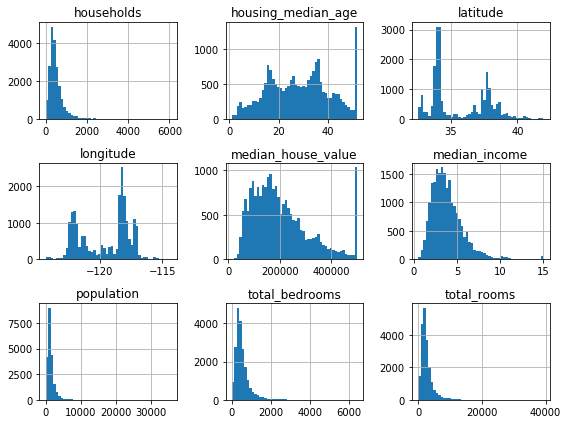

In [260]:
housing.hist(bins=50, figsize =(8,6))
plt.tight_layout()
plt.show();


### Splitting the data into a training set and a test set

At this point it is a good idea to split the dataset up into a training and test set. For very large datasets a random sample is fine (ie randomly generating a training set) but for small datasets we risk introducing a significant sample bias. For smaller datasets we should be employing stratisfied sampling. This is a reason why skewed distributions can make ML models perform poorly, a random sample may take many samples from the tail-end, which don't represent the majority of the population. To do this we create catergories that represent the distribution of the attribute of intrest. For example, median income is skewed, our sampling should try to replicate that. Scikit-learn has built in classes to perform different sampling methods. In the following we will create 5 categories based upon the median income attibute. 

In [261]:
from sklearn.model_selection import StratifiedShuffleSplit

#Create categories for stratified sampling 
housing['income_cat'] = np.ceil(housing["median_income"]/1.5)
housing['income_cat'].where(housing["income_cat"]<5, 5.0, inplace=True) 

split = StratifiedShuffleSplit( n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

In the split the random_state is set to an arbitary integer, in this case 42. This parameter initialises the random number generator used for sampling and ensures that the same test set will be generated each time the code is run. It is possible to print the counts in each catgory as shown below. 

In [262]:
print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


Now the split has been completed it's OK to drop the income catergory attribute and return the dataset back to its orginal form.

In [263]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

Create a copy of the training data to experiment with. 



### Visualising data further and creating new features

In [264]:
housing = strat_train_set.copy()

There is geographical data in this dataset; it is possble to plot the target variable as a function of latitude and longitude to look for spatial correlations. 

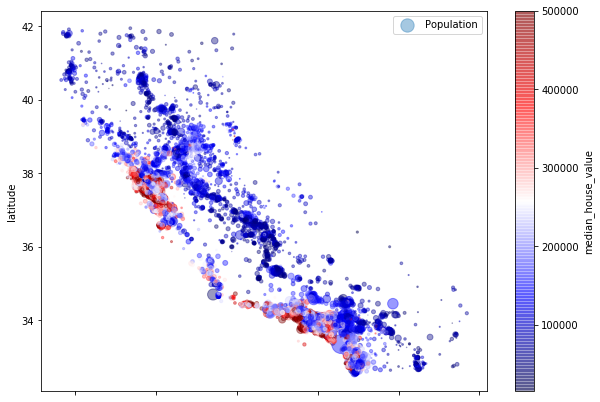

In [265]:
housing.plot(kind='scatter', x='longitude', y='latitude',alpha=0.4, s=housing['population']/100, label='Population', c='median_house_value',cmap=plt.get_cmap('seismic'), colorbar=True, figsize=(10,7));
#s=housing['population']/100 sets the size of the point to be proportional to the population

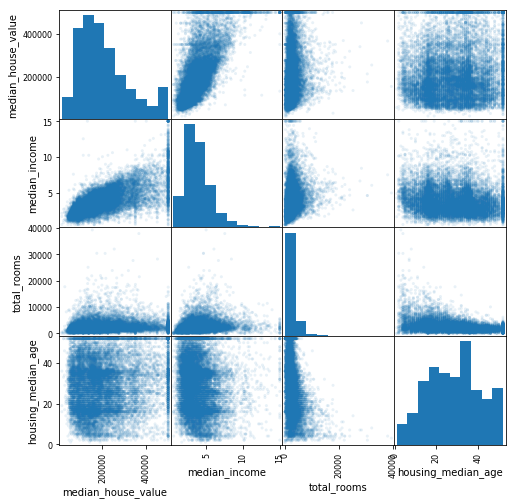

In [266]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms','housing_median_age']
pd.plotting.scatter_matrix(housing[attributes],alpha=0.1,figsize=(8,8));

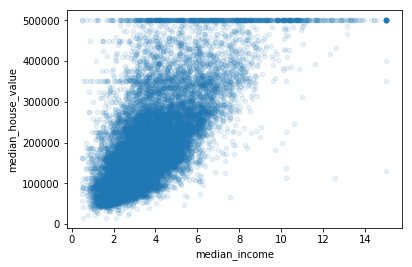

In [267]:
housing.plot(kind='scatter', x='median_income',y='median_house_value',alpha=0.1);

From first inspection there seems to be a positive correlation between median house value and the median income. **Note**, the horizontal lines in this data are due to artificial caps during data collection which are also observed in the histograms above. In particular the target variable 'median house value' is capped at 500,000 and has similar horizontal line features at lower values. This could be a problem for real ML projects as the model may learn to replicate these artificial features and it may be worth removing these instances. For now we will leave them as is. 

We can combine different attributes to create new ones which may have a stronger correlation with the target attribute than the existing ones. For example, total number of rooms per district is not useful for predicing the median house price. It is possile to construct a new attribute 'Number of rooms per house' by dividing the number of rooms per district by number of homes.


In [268]:
housing['rooms_per_home'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_house'] = housing['population']/housing['households']
housing['income_density'] = housing['median_income']/housing['population']

Calculaute the correlation with the median house value to see if any of the new attributes attributes correlate better than the original ones, and visualise them similar to above. 

In [269]:
corr_matrix = housing.corr()
print(corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value      1.000000
median_income           0.687160
rooms_per_home          0.146285
total_rooms             0.135097
income_density          0.115985
housing_median_age      0.114110
households              0.064506
total_bedrooms          0.047689
population_per_house   -0.021985
population             -0.026920
longitude              -0.047432
latitude               -0.142724
bedrooms_per_room      -0.259984
Name: median_house_value, dtype: float64


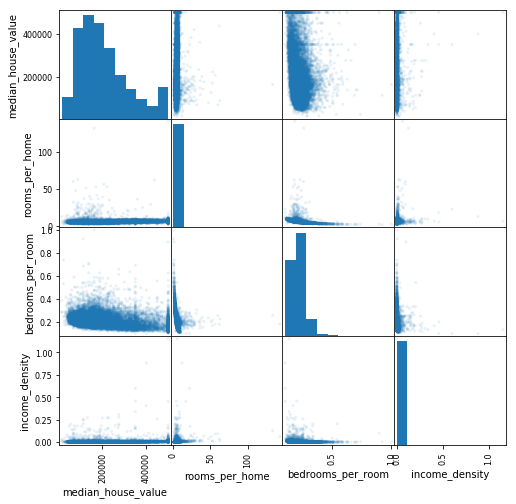

In [270]:
new_attributes = ['median_house_value','rooms_per_home','bedrooms_per_room','income_density']
pd.plotting.scatter_matrix(housing[new_attributes],alpha=0.1,figsize=(8,8));

While some of these new attributes have a higher correaltion with the target variable than some of the original attibutes, upon visualisation we see they all have very narrow distributions and may not perform well as regressors. It will be possible to look at which attributes are most important for making accurate predictions later when evaluting models. 

From the exploratory analysis we know that the total_bedrooms attribute has missing values which need to be accounted for before imputting th data into the model. We also know that there is a categorical attribute which needs to be encoded into numerical data if it is to be used by the following models. We have found artificial features in the dataset resulting from the data collection methods, which will be important to bear in mind when analysing the accuracy of the machine learning models later. We also know that the median income has the largest correlation with median house value and that new attributes 'rooms per home', 'population density' and 'bedrooms per home' have a higher correlation with the median house value than some of the original attributes.

***

## 2. Prepare the dataset for ML algorithms

The next stage is to prepare the data for the machine learning algorithm. This is acheived by performing a series of transformations to the data, using objects known in Scikit-learn as **transformers**. Transformers (as well as estimators and predictors) are represented as class objects in Scikit-learn which follow specific rules which will be mentioned again later. The transformations employed here will be filling missing values, encoding categorical data, adding extra attributes to the dataset using a custom transformer and feature scaling. At the end all of these transformations are organised into a **pipeline**.


### Using the Imputer class to fill missing values 

In [17]:
#Create a fresh training set
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy() #This sets median_house_value as the target attribute. 


Imputer will replace missing values according to a strategy, in this case the median value of that attribute. To use the imputer, first instansiate it and use the fit() method on the numerical data (categorical data must be dropped). The fit() method calculates the fill value of each feature and and stores them into a numpy array which can be accessed via the statistics attribute. It is important to **save these values** to replace missing data in the test set. 

In [272]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median') 

housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

print(imputer.statistics_)

[-1.18510000e+02  3.42600000e+01  2.90000000e+01  2.11950000e+03
  4.33000000e+02  1.16400000e+03  4.08000000e+02  3.54090000e+00
  1.79500000e+05  5.23228423e+00  2.03031374e-01  2.81765270e+00
  3.01783969e-03]


Once the median values have been caluclated the transform() method acts on the training data to fill the missing values.

In [19]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Encoding the categorical attribute

The categorical attributes must be encoded so that the ML system can process them. One-hot encoding is used to convert the categorical values into a binary vector such that no ordinal relationship is assumed between the categorical values. It is possible to pass a numpy array of category values directly to the encoder (as a 2D array).

In [20]:
from sklearn.preprocessing import OneHotEncoder 

In [21]:
category_values = housing['ocean_proximity'].values.reshape(-1,1)
encoder = OneHotEncoder() #Create OneHotEncoder instance
encoded_housing_categories = encoder.fit_transform(category_values)
print(type(encoded_housing_categories))

<class 'scipy.sparse.csr.csr_matrix'>


The one-hot encoder returns a sparse matrix. Each row is an instance and each column is a category value. Each row contains only one value of 1 and the rest are 0. The 1 indicates which which category value that instance takes. The sparse matrix only stores the location of the non-zero elements. 

### Building a custom transformer to add a new attribute

In order for a custom transformer to be Scikit-learn compatible, we need to define them as class objects with fit(), transform() and fit_transform() methods. This way custom transformers can be used with the Pipline class. This can be done manually or using the FunctionTransformer class.

Transformers need to be derived from the BaseEstimator base class (used for all estimators and transformers in Scikit-learn) and the TransformerMixin class. We define the fit() and transform() methods manually and inherit the fit_transform() method from TransformerMixin.

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

#Define the integer indexes for the columns used in the following transformer
rooms_idx, bedrooms_idx, population_idx, household_idx = 3,4,5,6

class BedroomPerRoomAdder(BaseEstimator,TransformerMixin):
    
    def __init__(self,add_bedrooms_per_room=True): 
        #add_bedrooms_per_room is a hyperparameter (if we add this feature or not)
        #and is set True by default. 
        
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    
    def fit(self,array, y=None):
        #Since we are not fitting any data (we transform it) the fit method
        #does nothing. The data input is included here, NOT in __init__.
        #In this case the input is a NumPy array.
        
        return self
    
    def transform(self, array, y=None):
        #The transform method takes input NumPy array, 'array' and applies 
        #the desired transformation defined below.
        
        rooms_per_household = array[:,rooms_idx]/array[:,household_idx]
        population_per_household = array[:,population_idx]/array[:,household_idx]
        if self.add_bedrooms_per_room: 
            #If self.add_bedrooms_per_room = True, add new atribute, if not return original.
            
            bedrooms_per_room = array[:,bedrooms_idx]/array[:,rooms_idx]
            return np.c_[array, rooms_per_household,population_per_household,bedrooms_per_room]
        
        else:
            return np.c_[array, rooms_per_household,population_per_household]

In [23]:
#Creating a class instance with add_bedrooms_per_room=False does nothing to our input
attribute_adder = BedroomPerRoomAdder(add_bedrooms_per_room=False)
housing_added_attributes = attribute_adder.transform(housing.values)


**Note** Since total number of rooms ranges from 6 to 39,320 and median income ranges from 0 to 15, the attributes should be rescaled so they all have the same scale. Scikit-learn provides classes for normalisation and standardisation. We will build this into the pipeline directly in the next section. 

## Building a transformation pipeline

In real projects we dont want to manually apply transformations as we have done above, so instead we create a pipline. Pipelines are used to execute the transformations in order (in fact we can also put the final prediction into a pipeline too). Pipelines for the numerical transformations and categorical transformations will be created separatley and then joined at the end using the FeatureUnion class.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transformation_steps = [('imputer',SimpleImputer(strategy='median')), ('attribute_adder',BedroomPerRoomAdder()),('std_scalar',StandardScaler())]
numerical_pipeline = Pipeline(transformation_steps)

This numerical pipeline first applies the imputer to the data using the strategy median, adds the attribute Bedrooms per Room using the custom transformer BedroomPerRoomAdder() and then scales the data using standardisation. 

It's not ideal to have to manually split the numerical data from the categorical data, instead build another custom transformer that can take a dataframe and return a reduced array with only the desired attributes, for example all the numerical attributes or all the categorical attributes. 

In [25]:
class AttributeSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, dataframe, y=None):
        return self
    
    def transform(self, dataframe):
        return dataframe[self.attribute_names].values

This transformer can be used to create two pipelines which first splits the data into numerical and categorical attributes, then applies the above steps to the numerical data and applied one-hot encoding to the categorical data.

In [26]:
from sklearn.pipeline import FeatureUnion


numerical_attributes = list(housing_num)
categorical_attributes = ['ocean_proximity']

numerical_transformation_steps = [('selector',AttributeSelector(numerical_attributes)),('imputer',SimpleImputer(strategy='median')), ('attribute_adder',BedroomPerRoomAdder()),('std_scalar',StandardScaler())]
numerical_pipeline = Pipeline(numerical_transformation_steps)

categorical_transformation_steps = [('selector',AttributeSelector(categorical_attributes)),('cat_encoder',OneHotEncoder())]
categorical_pipeline = Pipeline(categorical_transformation_steps)

transformer_list = [('numerical_pipeline',numerical_pipeline),('categorical_pipeline',categorical_pipeline)]
full_pipeline = FeatureUnion(transformer_list)


This full pipeline can be ran on the housing training set using the fit_transform() method and the data will automatically be prepared for input to machine learning algorithms!

In [27]:
prepared_housing_data = full_pipeline.fit_transform(housing)

***

## 3. Selecting and evaluating models

In this section we will use Linear Regression, Decision Tree Regresison and Random Forest Regression to predict the median house price. This will illustrate how to evaluate regression models using K-fold cross-validation and visualise the results.  

### Testing different models

#### Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(prepared_housing_data,housing_labels);

The model has been trained using the fit() method on the prepared data! There are many metrics to evaluate the model, in this case the root mean squared error (RMSE) will be used. 

In [29]:
from sklearn.metrics import mean_squared_error as mse

predictions = linear_reg.predict(prepared_housing_data)
MSE_linear_reg  = mse(housing_labels,predictions)
RMSE_linear_reg = np.sqrt(MSE_linear_reg)
print('RMSE_linear_regession:',RMSE_linear_reg)

RMSE_linear_regession: 68628.19819848923


This RMSE score is the mean prediction error; the interquatile range of Mean House Price is
145,125, so an error of 68,628 is almost 50% of the interquartile range of the target variable. This indicates that the prediction **varience is large** and the model is **underfitting**. Three main ways to reduce underfitting is to **use better features**, **reduce constraints** or to **select a more powerful model**. Since this model has no constraints it would be wise to look at creating better features. For example, could combining the latitude and longitude into a single coordinate correlate better with mean house prices than each component individually? We could also look at dropping some features that have the lowest correlation with the target variable. 

Before moving on to Decision Trees, we will look at how K-fold cross-validation provides a more detailed evaluation. K-fold cross-validation splits the training set into K subsets (folds), uses one of the subsets as a test set and the remaining subsets as training sets. It then trains the model on each subset and then evaluates it on the test set. The process then repeats a further K-1 times; during each iteration a different fold is used as the test set and the remaining folds are used as the training data and at the end there are K returned scores. Scikit-learn provides a convenient class for performing this process.

In [30]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(linear_reg,prepared_housing_data,housing_labels,scoring='neg_mean_squared_error',cv=10)
#cross_val_score useses a utility function as opposed to an error function.
#k is set to 10, this is an unoptimised guess

linear_RMSE_scores = np.sqrt(-1*scores)
print('Scores:', linear_RMSE_scores)
print('Mean:', linear_RMSE_scores.mean())
print('Std:', linear_RMSE_scores.std())

Scores: [66782.73844071 66960.11807344 70347.95241187 74739.57053053
 68031.13391576 71193.84181889 64969.63056867 68281.6113789
 71552.91570512 67665.10081597]
Mean: 69052.46136598417
Std: 2731.6740020610055


By using cross-validation we get a more in depth estimate of the model performance since we have 10 scores we can calucate mean and standard deviation. With a good model, the predicted values and the real values (labels) should have a linear relationship; when the label value increases, the model makes a proportionally higher prediction. We can plot the predictions against the labels to visualise this along with the line y = x.

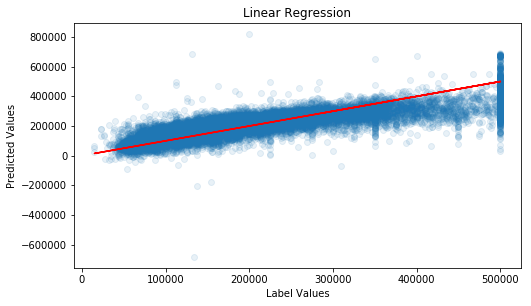

In [31]:
plt.figure(figsize=(8, 4.5))
plt.scatter(housing_labels,predictions,alpha=0.1)
plt.plot(housing_labels,housing_labels, 'r')
plt.title('Linear Regression')
plt.xlabel('Label Values')
plt.ylabel('Predicted Values');


Above values of approximately 300,000 the model predicting values below the true label values. It is possbile that this occurs because we did not remove capped values as mentioned earlier, or it could be some other consequence of underfitting. Let us move on to a different model, Decision Trees. 

#### Decision Tree Regression

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(prepared_housing_data,housing_labels)
predictions_tree = tree_reg.predict(prepared_housing_data)
MSE_tree_reg = mse(housing_labels,predictions_tree)
RMSE_tree_reg = np.sqrt(MSE_tree_reg)
print('RMSE_tree_regession:',RMSE_tree_reg)

RMSE_tree_regession: 0.0


This gives a RMSE value of 0 meaning the model fits the data perfectly. This is model is clearly **overfitting** and will not generalise to new data. This is confirmed when using cross-validation.

In [33]:
tree_scores = cross_val_score(tree_reg,prepared_housing_data,housing_labels,scoring='neg_mean_squared_error',cv=10)
RMSE_tree_scores = np.sqrt(-1*tree_scores)
print(RMSE_tree_scores)
print('Mean:', RMSE_tree_scores.mean())
print('Std:', RMSE_tree_scores.std())

[69257.70746289 66303.0121827  70397.02615433 68602.39588864
 70333.01162132 75798.900299   70937.98576921 73207.88053748
 77229.81021282 69639.93133183]
Mean: 71170.76614602219
Std: 3161.186041462424


The decision tree in fact has a very similar performance to the linear regression model when tested on new data. We can use the cross_val_predict class to plot the resuts from cross validation.We will not plot the results from the original fit since we know the RMSE is 0.0. **Note** cross_val_score returns the negative MSE score of each iteration of the cross-validation process, whereas cross_val_predict returns the predicted values. 

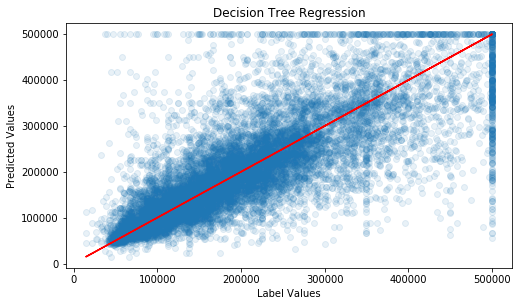

In [34]:
from sklearn.model_selection import cross_val_predict

cross_val_tree_predictions = cross_val_predict(tree_reg,prepared_housing_data,housing_labels,cv=10)

plt.figure(figsize=(8, 4.5))
plt.scatter(housing_labels,cross_val_tree_predictions,alpha=0.1)
plt.plot(housing_labels,housing_labels, 'r')
plt.title('Decision Tree Regression')
plt.xlabel('Label Values')
plt.ylabel('Predicted Values');



We can see that the the predicted values have a large varience. The model is overfitting the trining set and then performing badly on new data. Notice too there are more artificial features in this plot compared to that for linear regression, this suggests that the decision tree has learned to replicate the artificial features in its predictions. 

Random Forest models attempt to reduce overfitting by using an ensemble of decision trees. They are generated first by sampling a random subset of instances from the training set **with replacement** and the same instance can be sampled more than once, in a process known as **bootstrapping**. Then a decision tree is constructed using a random subset of attributes of the bootstrapped dataset; this process is repeated multiple times. The number of attibutes from the bootstrapped dataset you use to construct a decision tree, and the number of decision trees are hyperparameters of the model, which can be optimised. A new instance is passed through all the trees in the forest and the results are aggregated, with the idea of reducing the error due to single decision trees overfitting.  

#### Random Forest Regression

In [37]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_housing_data,housing_labels)
predictions_forest = forest_reg.predict(prepared_housing_data)
MSE_forest_reg = mse(housing_labels,predictions_forest)
RMSE_forest_reg = np.sqrt(MSE_forest_reg)
print('RMSE_forest_regession:',RMSE_forest_reg)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE_forest_regession: 22426.415108285073


In [585]:
forest_scores = cross_val_score(forest_reg,prepared_housing_data,housing_labels,scoring='neg_mean_squared_error',cv=10)
RMSE_forest_scores = np.sqrt(-1*forest_scores)
print(RMSE_forest_scores)
print('Mean:', RMSE_forest_scores.mean())
print('Std:', RMSE_forest_scores.std())

[53065.42483828 50184.8406743  52796.45115529 54664.76703236
 52522.51930719 55430.28168638 51435.70022334 49810.01311785
 55194.81792203 53463.59501662]
Mean: 52856.84109736546
Std: 1852.749097036651


When using cross-validation the RMSE is twice when trained on the whole training set at once, which shows the Random Forest still overfits, but performs better than the decision tree. We will continue with the Random Forest Model and look at hyperparameter optimization.

### Tuning Hyperparameters

There are many hyperparameters which can be tuned for a Random Forest which can be found in the doumentation, however here a gridsearch for the number of trees (n_estimators) and the numer of features to use in each tree (max_features). To do a grid search we can use the GridSearchCV class. First a grid is created, where each axis is a hyperparameter, and then K-fold cross validation is performed at each point of the grid; we will drop the number of folds from 10 to 5 to save computing time.

In [41]:
from sklearn.model_selection import GridSearchCV

parameter_grid = [{'n_estimators':[5,10,50],'max_features':[2,4,6,8]}]
grid_search = GridSearchCV(forest_reg,parameter_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(prepared_housing_data,housing_labels)

print(grid_search.best_params_)

{'max_features': 6, 'n_estimators': 50}


The above code performs 5-fold cross-validation for 12 hyperparameter values, the three n_estimator values multiplied by the 4 max_features values. The best score is calculated when n_esimators = 50 and max_features = 6. There is a GridSearchCV parameter called 'refit' which is equal to true by default, this parameter trains the model on the whole dataset with the best hyperparameters. It is possible to save the results into a dataframe. 

In [46]:
print(pd.DataFrame(grid_search.cv_results_))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.888154      0.020539         0.007838        0.001144   
1        1.897284      0.042722         0.013460        0.002694   
2        8.741751      0.079463         0.050939        0.003364   
3        1.410399      0.061404         0.007721        0.000705   
4        3.165653      0.178351         0.014461        0.002073   
5       14.483402      0.299541         0.055360        0.005990   
6        1.865419      0.017955         0.007256        0.000554   
7        3.705616      0.034098         0.011945        0.000459   
8       20.240171      1.096607         0.054287        0.001439   
9        2.680739      0.101745         0.007498        0.000457   
10       5.267669      0.160831         0.014022        0.002205   
11      25.446420      0.964205         0.056573        0.005209   

   param_max_features param_n_estimators  \
0                   2                  5   
1                   2      

The mean training score is the MSE for each of the 12 calculations, we can take this column and display it as a heatmap. 

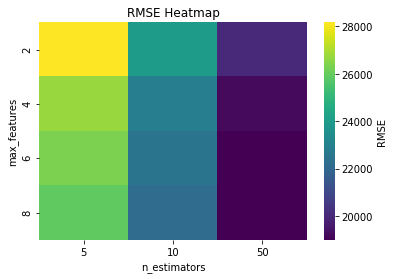

In [121]:
import seaborn as sns

axis1 = parameter_grid[0].get('n_estimators')
axis2 = parameter_grid[0].get('max_features')

grid_scores = np.sqrt(-1*grid_search.cv_results_['mean_train_score'])

#Correctly rearrange scores into 2D
RMSE_grid_scores = np.zeros((4,3))
RMSE_grid_scores[0] = grid_scores[:3]
RMSE_grid_scores[1] = grid_scores[3:6]
RMSE_grid_scores[2] = grid_scores[6:9]
RMSE_grid_scores[3] = grid_scores[9:12]

yticklabels = axis2
xticklabels = axis1
ax = sns.heatmap(RMSE_grid_scores,cmap='viridis',xticklabels=xticklabels,yticklabels=yticklabels,cbar_kws={'label': 'RMSE'})
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_features')
ax.set_title('RMSE Heatmap')
plt.show()


From this plot we can see that increasing the number of estimators is a more effective way to create a more accurate model than increasing the maximum number of features. In practice you may want to search more hyperparamater combinations but for now 12 combinations will do. It is also possible to visualise the realtive importance of each attribute in making accurate predictions. The feature importances are accessed via the feature_importances attribute of the RandomForestRegressor class. The total number of features is all the numerical features, any extra features we added and **one for each categorical value**: the random forest will evaluate the importance of each value in the categorical attribute, ocean proximity. 

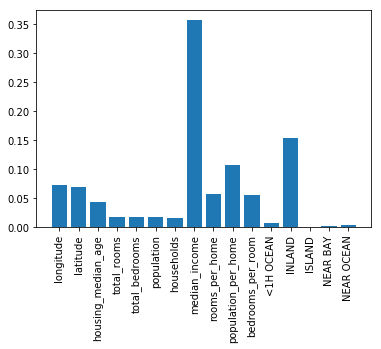

In [324]:
feature_importances = grid_search.best_estimator_.feature_importances_

category_value_attributes = list(categorical_pipeline.named_steps['cat_encoder'].categories_[0])
attributes = numerical_attributes+['rooms_per_home','population_per_home','bedrooms_per_room']+category_value_attributes

fig, ax = plt.subplots()
x = np.arange(len(attributes))
ax.bar(x,feature_importances)
ax.set_xticks(x)
ax.set_xticklabels(attributes,rotation=90)
plt.show()

From the bar chart we see that the most important feature in determing the the accuracy of the model is median_income, which could be expected since it has the strongest correaltion with the target variable. The extra attributes rooms_per_home,population_per_home and bedrooms_per_room were more important the district totals for the number of rooms, bedrooms, population and households. Furthermore, only one of the categorical values, INLAND, was found to be important for making an accurate prediction. From this we can identify features we may want to drop from the data.  

### Evaluating on the test set

In [124]:
final_model = grid_search

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

prepared_X_test = full_pipeline.transform(X_test)

final_prediction = final_model.predict(prepared_X_test)

MSE_final = mse(y_test,final_prediction)
RMSE_final = np.sqrt(MSE_final)
print('RMSE of final model:', RMSE_final)



RMSE of final model: 47418.459618459754


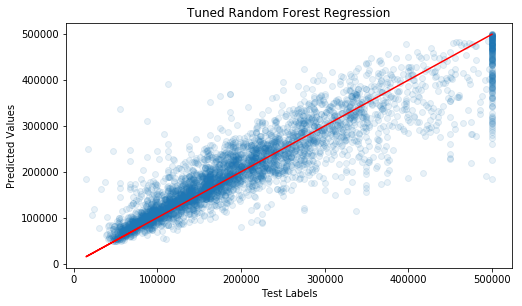

In [125]:
plt.figure(figsize=(8, 4.5))
plt.scatter(y_test,final_prediction,alpha=0.1)
plt.plot(y_test,y_test, 'r')
plt.title('Tuned Random Forest Regression')
plt.xlabel('Test Labels')
plt.ylabel('Predicted Values')
plt.show();

The RMSE of the Random Forest model is 47,418, 33% of the interquartile range, significantly better than what we started with using a Linear Regression model. Further data cleaning, feature engineering and hyperparameter tuning would likely yeild further accuracey of the model or may allow us to acheive the same accuracey with a less computationally expensive model. 

***

## 4. Learning outcomes and insights

Through this project we have looked at:

 - Inspecting data using Pandas and visualisation methods to understand the which data types are present, where data is missing, the distribution of attribute values and correlations between attributes 
 - Using Scikit-learn to split datasets into training and test sets
 - How to use Scikit-learn's built-in transformer classes and how to create custom transformers that are compatible with Scikit-learn
 - How to encode categorical data 
 - Automating workflows using pipelines
 - Training regression models and evauating them using a RMSE metric
 - Using K-fold cross-validation to check for overfitting and to get a more detalied evaluation
 - Visualising regression performance 
 - How to tune hyperparamters using a grid search with cross-validation and visualising the results 
 - How to retreive and visualise the importance of features from a random forest model.
 - Testing a final model on a training set
 
Some insights:

 - The median income is the best predictor of the median house price in a district. This is because it has the strongest correllation with the median house price and was determined to be the the most important predictor by the random forest. 
 - The spatial data showed two regions of high median house price; using a clustering algorithm to split these regions into clusters and measuring the distance from the center of these clusters could be a way to create a useful, new attribute. 
 - Artificial features in the data, especially in the target variable, influence the predictions of machine learning algorithms. This was most prominant in the decision tree model and the effects of artificial data appear to have been reduced by using an ensemble method (random forest). 
 

 